In [1]:
# Step 1: Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Step 2: Load TensorFlow Flowers dataset
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True, shuffle_files=True)

train_dataset = dataset['train']

In [3]:
# Step 3: Split into train, validation, test
train_size = 0.7
val_size = 0.15
test_size = 0.15

train_ds = train_dataset.take(int(info.splits['train'].num_examples * train_size))
val_ds = train_dataset.skip(int(info.splits['train'].num_examples * train_size)).take(int(info.splits['train'].num_examples * val_size))
test_ds = train_dataset.skip(int(info.splits['train'].num_examples * (train_size + val_size)))

In [4]:
# Step 4: Preprocessing
IMG_SIZE = 160
BATCH_SIZE = 32

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

train_ds = train_ds.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

class_names = info.features['label'].names
print("Class names:", class_names)


Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
# Step 5: Build Transfer Learning Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# Step 6: Train the Model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5)

Epoch 1/5
81/81 [==============================] - 23s 256ms/step - loss: 0.9736 - accuracy: 0.6415 - val_loss: 0.5515 - val_accuracy: 0.8055
Epoch 2/5
81/81 [==============================] - 18s 218ms/step - loss: 0.4842 - accuracy: 0.8291 - val_loss: 0.4515 - val_accuracy: 0.8455
Epoch 3/5
81/81 [==============================] - 18s 222ms/step - loss: 0.3823 - accuracy: 0.8610 - val_loss: 0.4106 - val_accuracy: 0.8527
Epoch 4/5
81/81 [==============================] - 18s 224ms/step - loss: 0.3437 - accuracy: 0.8813 - val_loss: 0.3761 - val_accuracy: 0.8618
Epoch 5/5
81/81 [==============================] - 19s 230ms/step - loss: 0.2901 - accuracy: 0.9000 - val_loss: 0.3832 - val_accuracy: 0.8455


In [7]:
# Step 7: Evaluate on Test Set
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")

18/18 [==============================] - 4s 172ms/step - loss: 0.3197 - accuracy: 0.8893
Test Accuracy: 88.93%


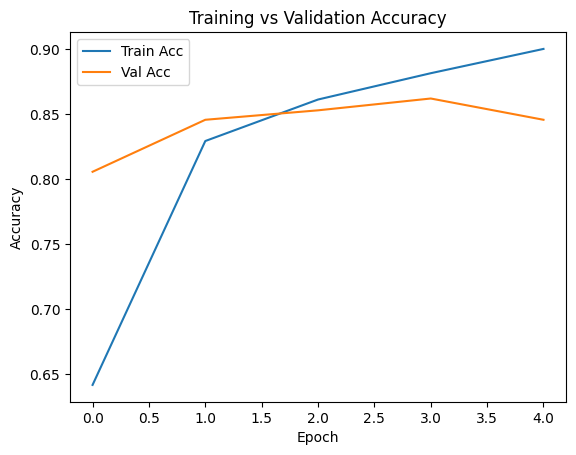

In [8]:
# Step 8: Visualization of Training
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

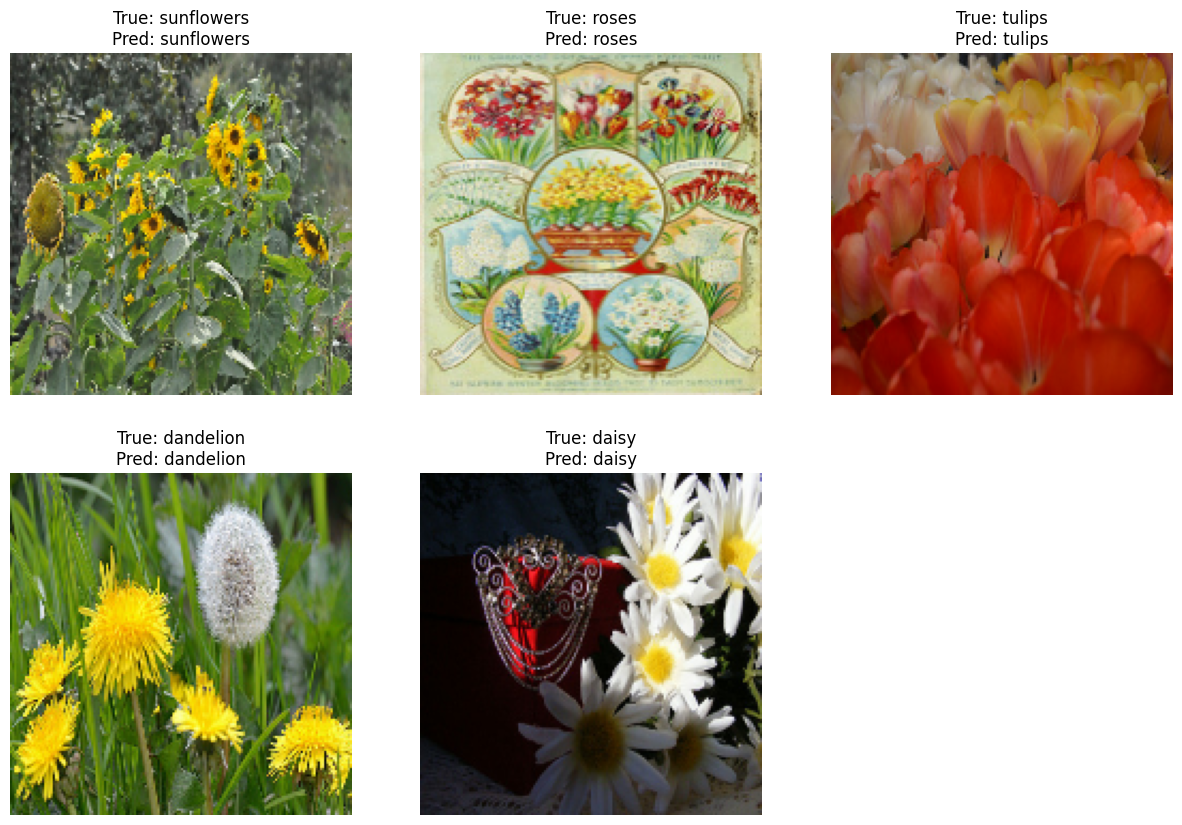

In [9]:
# Step 9: Show One Example per Class with Prediction
plt.figure(figsize=(15, 10))
shown_classes = set()
i = 1
for images, labels in test_ds.unbatch().take(500):  # check first 500 test samples
    label = labels.numpy()
    if label not in shown_classes:
        ax = plt.subplot(2, 3, i)
        plt.imshow(images.numpy())
        
        # Model prediction
        img_array = tf.expand_dims(images, 0)  # add batch dimension
        predictions = model.predict(img_array, verbose=0)
        pred_label = np.argmax(predictions[0])
        
        plt.title(f"True: {class_names[label]}\nPred: {class_names[pred_label]}")
        plt.axis("off")
        
        shown_classes.add(label)
        i += 1
        if len(shown_classes) == len(class_names):
            break
plt.show()